In [2]:
# AcousticTB: TB Screening from Cough Analysis
'''
This notebook guides you through the entire pipeline:
1. Data augmentation (clean + noisy mel-spectrograms)  
2. Train a light CNN encoder and extract embeddings  
3. Train tuned XGBoost on embeddings  
4. Train an MLP head for final stacking  
5. Evaluation and plots
'''

#The code omits the full RandomizedSearchCV—parameters pre-set to your best.

'\nThis notebook guides you through the entire pipeline:\n1. Data augmentation (clean + noisy mel-spectrograms)  \n2. Train a light CNN encoder and extract embeddings  \n3. Train tuned XGBoost on embeddings  \n4. Train an MLP head for final stacking  \n5. Evaluation and plots\n'

In [2]:
from pathlib import Path
BASE_DIR = Path().resolve()
RAW_AUDIO_DIR = BASE_DIR/"data"/"raw"/"solicited_coughs"/"audio"
META_DIR = BASE_DIR/"data"/"raw"/"solicited_coughs"/"metadata"
PROCESSED_DIR = BASE_DIR/"data"/"processed"
FEAT_DIR = PROCESSED_DIR/"features"

print(f"BASE_DIR = {BASE_DIR}")
print(f"Found {len(list(RAW_AUDIO_DIR.glob('*.wav')))} .wav files")

BASE_DIR = /Users/saatvik/AcousticTB
Found 9772 .wav files


In [ ]:
%run src/data_agumentation.py

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from collections import Counter
from pathlib import Path
BASE_DIR=Path().resolve()
src_dir=BASE_DIR/"src"
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [3]:
def tb_composite_score(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return 0.56 * sensitivity + 0.44 * specificity

def load_all_from_processed_clean(noisy_csv: str):
    df = pd.read_csv(noisy_csv)
    
    meta_dir = Path(noisy_csv).parent.parent / "raw" / "solicited_coughs" / "metadata"
    meta_path = meta_dir / "CODA_TB_additional_variables_train.csv"
    
    if meta_path.exists():
        meta_df = pd.read_csv(meta_path)
    else:
        meta_df = None
    
    spectrograms = []
    labels = []
    clinical_data = []
    noise_types = []
    base_patient_ids = []
    
    for i, row in df.iterrows():
        feat_path = Path(noisy_csv).parent / "features" / row['feature_file']
        if feat_path.exists():
            spec = np.load(feat_path)
            spectrograms.append(spec)
            
            tb_status = 0
            if meta_df is not None:
                participant_matches = meta_df[meta_df['participant'] == row['participant']]
                if not participant_matches.empty:
                    participant_row = participant_matches.iloc[0]
                    if 'Microbiologicreferencestandard' in participant_row:
                        tb_status = 1 if str(participant_row['Microbiologicreferencestandard']).upper() == 'POSITIVE' else 0
                    elif 'Sputumxpertreferencestandard' in participant_row:
                        tb_status = 1 if str(participant_row['Sputumxpertreferencestandard']).upper() == 'POSITIVE' else 0
            
            labels.append(tb_status)
            noise_types.append(row['noise_type'])
            base_patient_ids.append(row['base_patient_id'])
            
            clinical_features = [0.0] * 7
            if meta_df is not None:
                participant_matches = meta_df[meta_df['participant'] == row['participant']]
                if not participant_matches.empty:
                    participant_row = participant_matches.iloc[0]
                    
                    hiv_positive = 1.0 if str(participant_row.get('HIVstatus', '')).upper() == 'POSITIVE' else 0.0
                    hiv_unknown = 1.0 if str(participant_row.get('HIVstatus', '')).upper() == 'UNKNOWN' else 0.0
                    
                    country_sa = 1.0 if str(participant_row.get('Country', '')) == 'SA' else 0.0
                    country_ug = 1.0 if str(participant_row.get('Country', '')) == 'UG' else 0.0
                    country_tz = 1.0 if str(participant_row.get('Country', '')) == 'TZ' else 0.0
                    
                    num_coughs = float(participant_row.get('Numberofcoughsoundscollected', 0)) if pd.notna(participant_row.get('Numberofcoughsoundscollected', 0)) else 0.0
                    
                    clinical_features = [
                        hiv_positive,
                        hiv_unknown,
                        country_sa,
                        country_ug,
                        country_tz,
                        num_coughs / 20.0,
                        float(row.get('sound_prediction_score', 0)) if pd.notna(row.get('sound_prediction_score', 0)) else 0.0
                    ]
            clinical_data.append(clinical_features)
    
    X_spec = np.array(spectrograms)
    y = np.array(labels)
    X_clin = np.array(clinical_data)
    
    return X_spec, y, X_clin, noise_types, base_patient_ids

In [4]:
noisy_csv = BASE_DIR/"data"/"processed"/"solicited_metadata_with_noise.csv"
X_spec, y, Xclin, noise_types, groups = load_all_from_processed_clean(str(noisy_csv))

print(f"Loaded x_spec shape: {X_spec.shape} and labels={len(y)}")
print(f"Noise distribution: {Counter(noise_types)}")

Loaded x_spec shape: (29316, 64, 64) and labels=29316
Noise distribution: Counter({'clean': 9772, 'environmental': 9772, 'gaussian': 9772})


In [5]:
import glob
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
import time

n, h, w = X_spec.shape
X_flat = X_spec.reshape(n, h * w)
X_all = np.hstack([X_flat, Xclin])

random_seed = int(time.time()) % 10000
print(f"Using random seed: {random_seed}")

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(splitter.split(X_all, y, groups=groups))

X_tr = X_all[train_idx]
y_tr = y[train_idx]
X_val = X_all[val_idx]
y_val = y[val_idx]
Xclin_tr = Xclin[train_idx]
Xclin_val = Xclin[val_idx]

train_patients = set([groups[i] for i in train_idx])
val_patients = set([groups[i] for i in val_idx])
overlap = train_patients & val_patients

print(f"Class distribution - Train: TB+ {sum(y_tr)}/{len(y_tr)} ({100*sum(y_tr)/len(y_tr):.1f}%)")
print(f"Class distribution - Val: TB+ {sum(y_val)}/{len(y_val)} ({100*sum(y_val)/len(y_val):.1f}%)")
print(f"Patient overlap check: {len(overlap)} overlapping patients")

Using random seed: 2126
Class distribution - Train: TB+ 7011/23451 (29.9%)
Class distribution - Val: TB+ 1779/5865 (30.3%)
Patient overlap check: 0 overlapping patients


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

tf_random_seed = 42  
tf.random.set_seed(tf_random_seed)
np.random.seed(tf_random_seed)
print(f"TensorFlow random seed: {tf_random_seed}")

def calculate_class_weights(y_train):
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    return dict(zip(classes, weights))

def focal_loss(gamma=1.0, alpha=0.7):
    def fl(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)      
        epsilon = 1e-7 
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        ce_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        
        focal_weight = alpha_t * tf.pow(1 - p_t, gamma)
        focal_loss = focal_weight * ce_loss
        
        return tf.reduce_mean(focal_loss)
    return fl

X_cnn = X_spec.reshape(-1, h, w, 1)
X_cnn_tr = X_cnn[train_idx]
X_cnn_val = X_cnn[val_idx]

print(f"CNN Data Summary:")
print(f"- Train shape: {X_cnn_tr.shape}, Val shape: {X_cnn_val.shape}")
print(f"- Data range: [{X_cnn_tr.min():.1f}, {X_cnn_tr.max():.1f}]")
print(f"- Class distribution: TB+ {sum(y_tr)}/{len(y_tr)} ({100*sum(y_tr)/len(y_tr):.1f}%)")

X_mean = X_cnn_tr.mean()
X_std = X_cnn_tr.std()
X_cnn_tr = (X_cnn_tr - X_mean) / X_std
X_cnn_val = (X_cnn_val - X_mean) / X_std
class_weights = calculate_class_weights(y_tr)
print(f"Class weights: {class_weights}")

with tf.device('/GPU:0' if gpus else '/CPU:0'):
    inputs = Input(shape=(h, w, 1))
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.05)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu', name='embedding')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    cnn = Model(inputs=inputs, outputs=outputs)

cnn.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0003, weight_decay=1e-4),
    loss=focal_loss(gamma=1.0, alpha=0.7),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',  
        patience=10, 
        restore_best_weights=True, 
        verbose=1, 
        mode='min',
        min_delta=0.005
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.7,  
        patience=5, 
        min_lr=1e-6, 
        verbose=1, 
        mode='min',
        min_delta=0.005
    )
]

print(f"Model has {cnn.count_params():,} parameters")

history = cnn.fit(
    X_cnn_tr, y_tr,
    validation_data=(X_cnn_val, y_val),
    epochs=60,  
    batch_size=64, 
    callbacks=callbacks,
    verbose=1,
    shuffle=True,
    class_weight=class_weights
)

val_pred_proba = cnn.predict(X_cnn_val, verbose=0)
print(f"Prediction shape: {val_pred_proba.shape}")
print(f"Prediction range: [{val_pred_proba.min():.4f}, {val_pred_proba.max():.4f}]")
print(f"Prediction mean: {val_pred_proba.mean():.4f}")
print(f"Unique predictions count: {len(np.unique(val_pred_proba))}")

cnn_proba = val_pred_proba[:, 0]

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\nCNN Results at different thresholds:")
for thresh in thresholds:
    cnn_pred = (cnn_proba > thresh).astype(int)
    accuracy = accuracy_score(y_val, cnn_pred)
    print(f"Threshold {thresh}: Accuracy: {accuracy:.4f}, TB+ pred: {sum(cnn_pred)}, TB- pred: {len(cnn_pred)-sum(cnn_pred)}")

print(f"\nCNN AUC: {roc_auc_score(y_val, cnn_proba):.4f}")

embed_model = Model(inputs=cnn.input, outputs=cnn.get_layer('embedding').output)

TensorFlow random seed: 42
CNN Data Summary:
- Train shape: (23451, 64, 64, 1), Val shape: (5865, 64, 64, 1)
CNN Data Summary:
- Train shape: (23451, 64, 64, 1), Val shape: (5865, 64, 64, 1)
- Data range: [-80.0, 0.0]
- Class distribution: TB+ 7011/23451 (29.9%)
- Data range: [-80.0, 0.0]
- Class distribution: TB+ 7011/23451 (29.9%)
Class weights: {np.int64(0): np.float64(0.7132299270072993), np.int64(1): np.float64(1.6724433033804023)}
Class weights: {np.int64(0): np.float64(0.7132299270072993), np.int64(1): np.float64(1.6724433033804023)}
Model has 337,889 parameters
Model has 337,889 parameters
Epoch 1/60
Epoch 1/60
367/367 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.5334 - auc: 0.5376 - loss: 0.1948 - val_accuracy: 0.6967 - val_auc: 0.5959 - val_loss: 0.1690 - learning_rate: 3.0000e-04
Epoch 2/60
367/367 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.5334 - auc: 0.5376 - loss: 0.1948 - val_accuracy: 0.6967 - val_auc: 0.5959 - val_loss: 0.1690 - learning_rate: 3.0000e-04
Epoc

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
import numpy as np
from sklearn.metrics import confusion_matrix
import time

X_emb_tr = embed_model.predict(X_cnn_tr)
X_emb_val = embed_model.predict(X_cnn_val)

Xg_tr = np.hstack([X_emb_tr, Xclin_tr])
Xg_val = np.hstack([X_emb_val, Xclin_val])

grp_tr = np.array([groups[i] for i in train_idx])

def tb_focused_score(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return 0.56 * sensitivity + 0.44 * specificity 

tb_scorer = make_scorer(tb_focused_score, greater_is_better=True)

class_0_count = len(y_tr) - sum(y_tr)
class_1_count = sum(y_tr)
class_ratio = class_0_count / class_1_count

xgb_random_seed = int(time.time()) % 10000
print(f"XGBoost random seed: {xgb_random_seed}")

pipe = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler()),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        random_state=xgb_random_seed,
        tree_method="hist", 
        n_jobs=-1,
        booster="gbtree",
        scale_pos_weight=class_ratio * 3,  
        eval_metric="auc"
    ))
])

param_dist = {
    "clf__learning_rate": uniform(0.05, 0.15),  
    "clf__n_estimators": randint(300, 800),     
    "clf__max_depth": randint(4, 8),              
    "clf__subsample": uniform(0.7, 0.3),
    "clf__colsample_bytree": uniform(0.7, 0.3),
    "clf__reg_alpha": uniform(0.0, 0.1),          
    "clf__reg_lambda": uniform(0.1, 0.2),         
    "clf__min_child_weight": randint(1, 4),
    "clf__scale_pos_weight": uniform(3.0, 6.0),   
}

cv_random_seed = int(time.time()) % 10000
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=cv_random_seed)

rs_random_seed = int(time.time()) % 10000
rs = RandomizedSearchCV(
    pipe, 
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,  
    scoring=tb_scorer,
    verbose=1,
    n_jobs=-1, 
    random_state=rs_random_seed,
    refit=True
)

print("Starting XGBoost hyperparameter search...")
rs.fit(Xg_tr, y_tr, groups=grp_tr)

best_xgb = rs.best_estimator_
xgb_pred = best_xgb.predict(Xg_val)
xgb_proba = best_xgb.predict_proba(Xg_val)[:, 1]

cv_stack_seed = int(time.time()) % 10000
cv_stack = StratifiedKFold(n_splits=5, shuffle=True, random_state=cv_stack_seed)
oof_proba = cross_val_predict(
    best_xgb, Xg_tr, y_tr, 
    cv=cv_stack, method='predict_proba', n_jobs=-1
)[:, 1]

stack_X_tr = np.column_stack([oof_proba, Xclin_tr])

param_grid_lr = {
    'C': [0.1, 1.0, 10.0, 100.0],                 
    'penalty': ['l2'],                                  
    'solver': ['lbfgs'],                                
    'max_iter': [2000],
    'class_weight': ['balanced', {0: 1, 1: class_ratio * 2}]  
}

lr_random_seed = int(time.time()) % 10000
lr_search = GridSearchCV(
    LogisticRegression(random_state=lr_random_seed),
    param_grid_lr,
    cv=5,
    scoring=tb_scorer,
    n_jobs=-1,
    verbose=1
)

print("Starting Logistic Regression search...")
lr_search.fit(stack_X_tr, y_tr)
stacker = lr_search.best_estimator_

print(f"Best XGBoost CV score: {rs.best_score_:.4f}")
print(f"Best Logistic Regression params: {lr_search.best_params_}")
print(f"Best LR CV score: {lr_search.best_score_:.4f}")

xgb_val_proba = best_xgb.predict_proba(Xg_val)[:, 1]
stack_X_val = np.column_stack([xgb_val_proba, Xclin_val])

y_pred_stacked = stacker.predict(stack_X_val)
y_proba_stacked = stacker.predict_proba(stack_X_val)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_val, y_pred_stacked).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nFinal Results:")
print(f"Stacked Accuracy: {accuracy_score(y_val, y_pred_stacked):.4f}")
print(f"Stacked AUC: {roc_auc_score(y_val, y_proba_stacked):.4f}")
print(f"Sensitivity: {sensitivity:.4f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.1f}%)")
print(f"XGBoost AUC: {roc_auc_score(y_val, xgb_proba):.4f}")
print(f"CNN AUC: {roc_auc_score(y_val, cnn_proba):.4f}")
print(f"Improvement over XGBoost: {roc_auc_score(y_val, y_proba_stacked) - roc_auc_score(y_val, xgb_proba):+.4f} AUC")

print(f"\nMean probabilities:")
print(f"CNN: {np.mean(cnn_proba):.3f}")
print(f"XGBoost: {np.mean(xgb_proba):.3f}")
print(f"Stacked: {np.mean(y_proba_stacked):.3f}")

lr_coeffs = stacker.coef_[0]
print(f"\nLogistic Regression Coefficients:")
print(f"XGBoost probability weight: {lr_coeffs[0]:.4f}")
clinical_names = ['HIV_Positive', 'HIV_Unknown', 'Country_SA', 'Country_UG', 'Country_TZ', 'Num_Coughs_Norm', 'Sound_Score']
for i, name in enumerate(clinical_names):
    print(f"{name} weight: {lr_coeffs[i+1]:.4f}")

733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
XGBoost random seed: 4197
Starting XGBoost hyperparameter search...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
XGBoost random seed: 4197
Starting XGBoost hyperparameter search...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Starting Logistic Regression search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Starting Logistic Regression search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGBoost CV score: 0.8408
Best Logistic Regression params: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR CV score: 0.8877

Final Results:
Stacked Accuracy: 0.7812
Stacked AUC: 0.8501
Sensitivity: 0.7291 (72.9%)
Specificity: 0.8040 (80.4%)
XGBoost AUC: 0.8542
CNN AUC: 0.7243
Improvement over XGBoost: -0.0041 AUC

Mean 

ACOUSTICTB: COMPREHENSIVE MODEL EVALUATION & ANALYSIS

THRESHOLD OPTIMIZATION FOR TB SCREENING:
Senstivity 0.8785834738617201, Specificity 0.6150269211943221 at threshold 0.10
Senstivity 0.8442945474985947, Specificity 0.6767009300048947 at threshold 0.15
Senstivity 0.8206857785272625, Specificity 0.7116984826235928 at threshold 0.20
Senstivity 0.8032602585722316, Specificity 0.7351933431228586 at threshold 0.25
Senstivity 0.7863968521641371, Specificity 0.7508565834557024 at threshold 0.30
Senstivity 0.7689713322091062, Specificity 0.7640724424865394 at threshold 0.35
Senstivity 0.7549184935356942, Specificity 0.7765540871267743 at threshold 0.40
Senstivity 0.7414277684092186, Specificity 0.788546255506608 at threshold 0.45
Senstivity 0.729061270376616, Specificity 0.8039647577092511 at threshold 0.50
Senstivity 0.7088251826869028, Specificity 0.8184043073910915 at threshold 0.55
Senstivity 0.688026981450253, Specificity 0.8321096426823299 at threshold 0.60
Senstivity 0.67116357504215

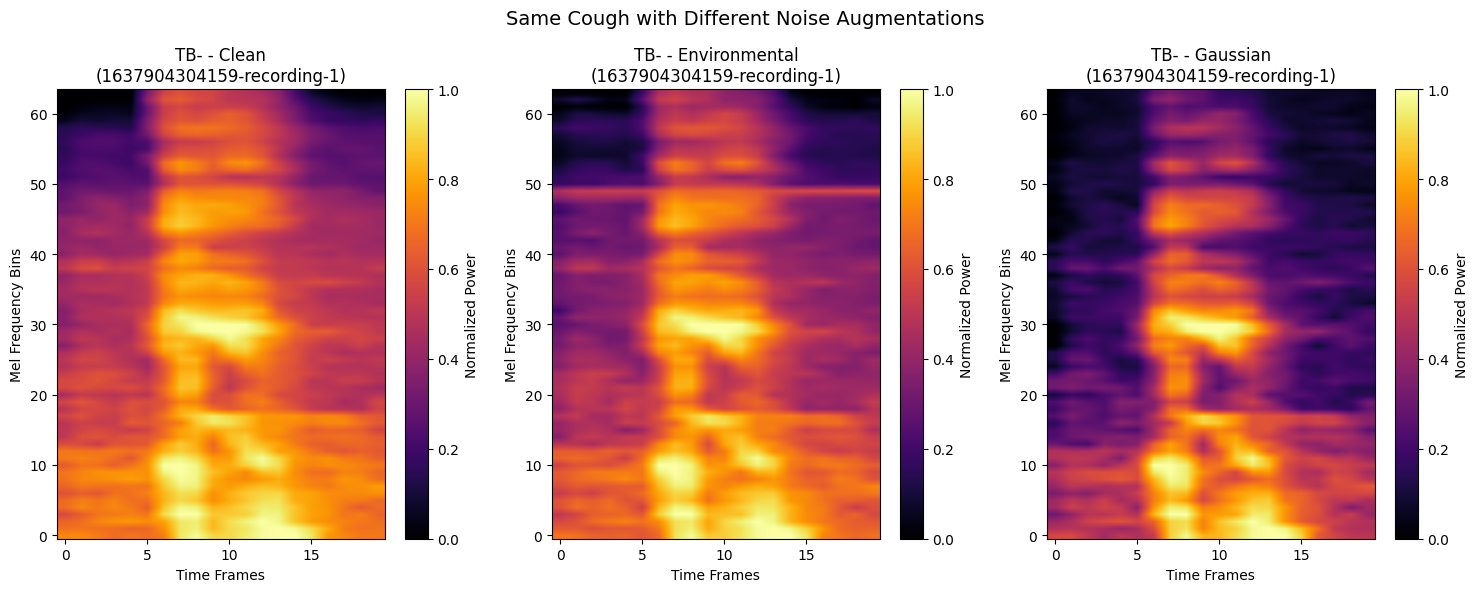

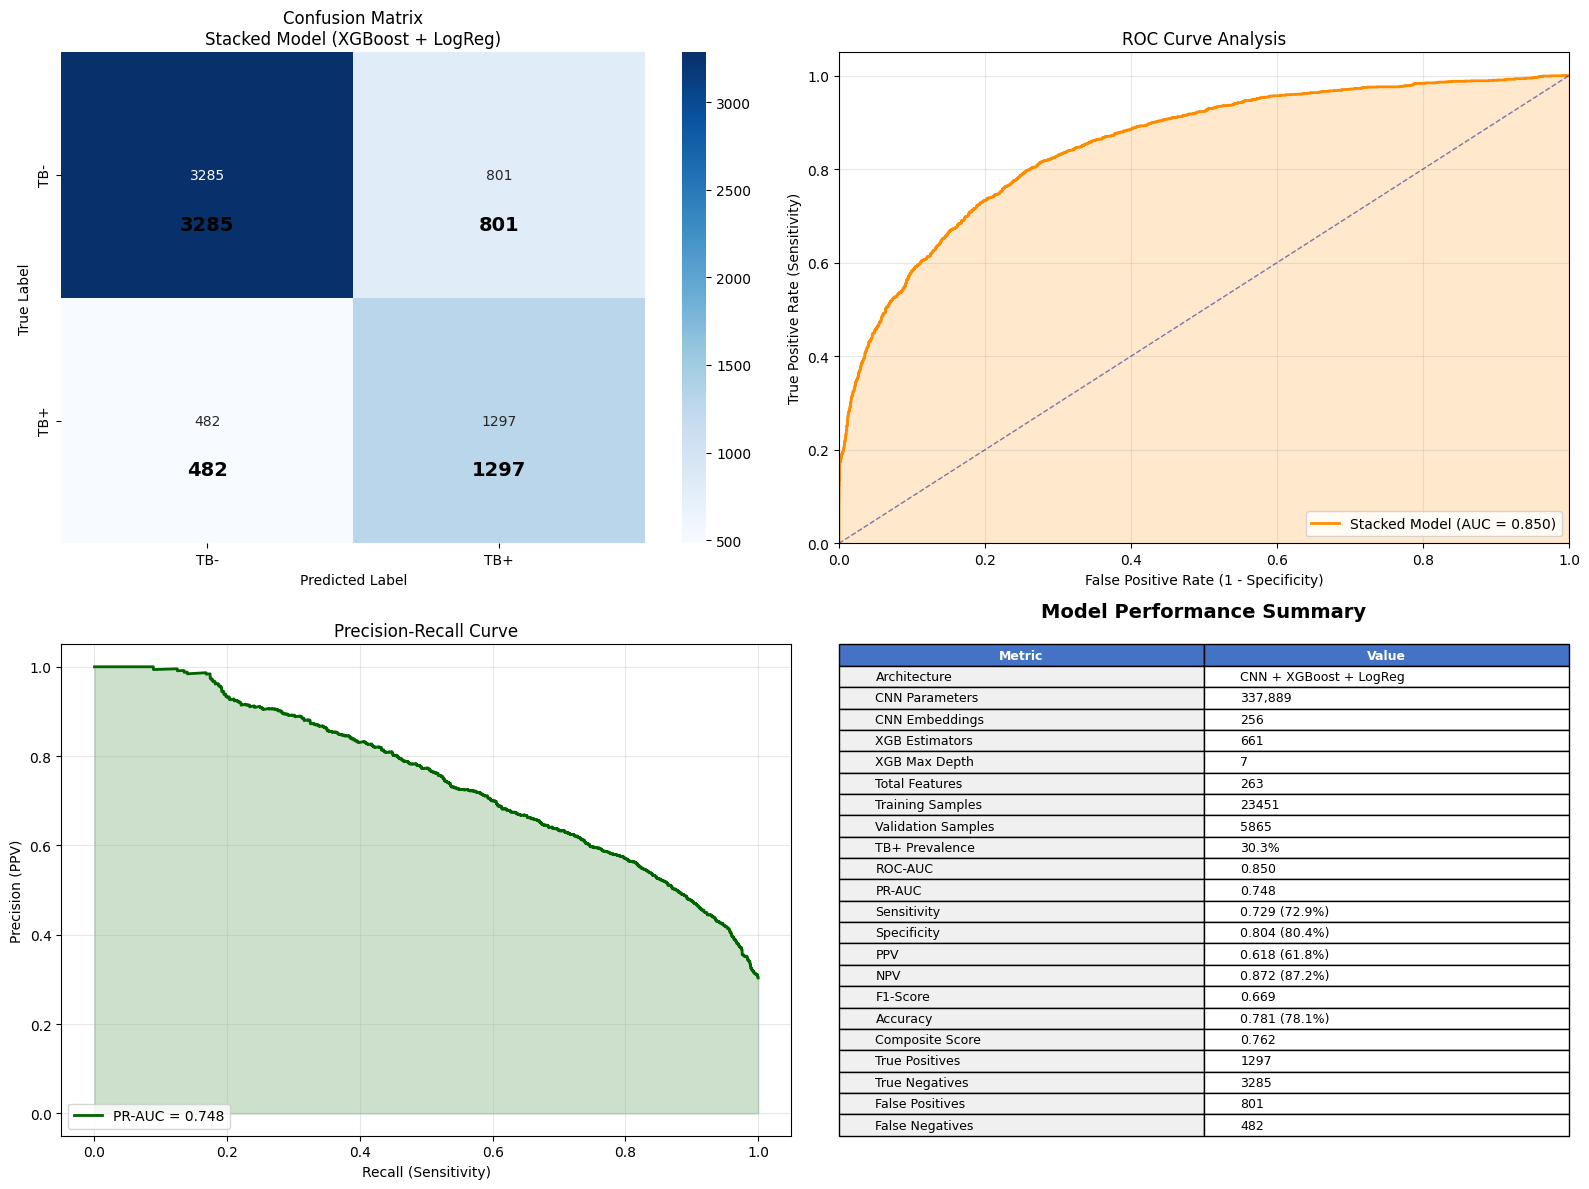


NOISE RESILIENCE ANALYSIS:
GAUSSIAN     | Samples: 1955 | Acc: 0.784 | Sens: 0.747 | Spec: 0.800 | AUC: 0.855
ENVIRONMENTAL | Samples: 1955 | Acc: 0.773 | Sens: 0.686 | Spec: 0.811 | AUC: 0.833
CLEAN        | Samples: 1955 | 
Acc: 0.787 | AUC: 0.862 (Baseline)

XGBoost Hyperparameters:
- learning_rate: 0.07511554619234062
- n_estimators: 661
- max_depth: 7
- subsample: 0.8319630165895023
- colsample_bytree: 0.8447907234333705
- reg_alpha: 0.02233650756046497
- reg_lambda: 0.26885165003548794
- scale_pos_weight: 6.189624933786702

Logistic Regression Stacker:
- Solver: lbfgs
- Max iterations: 2000
- Regularization: L2 (C=0.1)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

print("="*80)
print("ACOUSTICTB: COMPREHENSIVE MODEL EVALUATION & ANALYSIS")
print("="*80)
y_pred = y_pred_stacked
y_proba = y_proba_stacked
print(f"\nTHRESHOLD OPTIMIZATION FOR TB SCREENING:")
print("="*50)
thresholds = np.arange(0.1, 0.9, 0.05)
for thresh in thresholds:
    y_pred_t = (y_proba >= thresh).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_val, y_pred_t).ravel()
    sens_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    spec_t = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
    print(f"Senstivity {sens_t}, Specificity {spec_t} at threshold {thresh:.2f}")
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
npv = tn / (tn + fn)
ppv = tp / (tp + fp)

fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall_vals, precision_vals)

comp_score = tb_composite_score(y_val, y_pred)

print(f"DATASET STATISTICS:")
print(f"Total samples: {len(y_val)} | TB+: {sum(y_val)} ({100*sum(y_val)/len(y_val):.1f}%) | TB-: {len(y_val)-sum(y_val)} ({100*(len(y_val)-sum(y_val))/len(y_val):.1f}%)")
print(f"Training patients: {len(train_patients)} | Validation patients: {len(val_patients)}")

print(f"\nCORE CLINICAL METRICS:")
print(f"Sensitivity (Recall): {sensitivity:.3f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.3f} ({specificity*100:.1f}%)")
print(f"PPV (Precision): {precision:.3f} ({precision*100:.1f}%)")
print(f"NPV: {npv:.3f} ({npv*100:.1f}%)")
print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"F1-Score: {f1_score:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC: {pr_auc:.3f}")
print(f"Composite Score: {comp_score:.3f}")

val_base_ids = [groups[i] for i in val_idx]
unique_base_ids = list(set(val_base_ids))

selected_base_id = None
for base_id in unique_base_ids[:10]: 
    base_indices = [i for i, bid in enumerate(val_base_ids) if bid == base_id]
    base_noise_types = [noise_types[val_idx[i]] for i in base_indices]
    if len(set(base_noise_types)) >= 2:  
        selected_base_id = base_id
        break

if selected_base_id:
    base_indices = [i for i, bid in enumerate(val_base_ids) if bid == selected_base_id]
    base_noise_types = [noise_types[val_idx[i]] for i in base_indices]
    base_labels = [y_val[i] for i in base_indices]
    
    noise_types_viz = ['clean', 'environmental', 'gaussian']
    available_types = [nt for nt in noise_types_viz if nt in base_noise_types]
    
    fig_spec, axes_spec = plt.subplots(1, len(available_types), figsize=(5*len(available_types), 6))
    if len(available_types) == 1:
        axes_spec = [axes_spec]
    
    for i, noise_type in enumerate(available_types):
        for idx_pos in base_indices:
            if noise_types[val_idx[idx_pos]] == noise_type:
                mel_spec = X_spec[val_idx[idx_pos]]
                mel_cropped = mel_spec[:, :20] 
                
                p1, p99 = np.percentile(mel_cropped, [1, 99])
                mel_clipped = np.clip(mel_cropped, p1, p99)
                mel_normalized = (mel_clipped - p1) / (p99 - p1) if p99 > p1 else mel_clipped
                
                im = axes_spec[i].imshow(mel_normalized, cmap='inferno', aspect='auto', origin='lower', 
                                       vmin=0, vmax=1, interpolation='bilinear')
                axes_spec[i].set_title(f'{"TB+" if base_labels[0] else "TB-"} - {noise_type.title()}\n({selected_base_id})')
                axes_spec[i].set_xlabel('Time Frames')
                axes_spec[i].set_ylabel('Mel Frequency Bins')
                plt.colorbar(im, ax=axes_spec[i], label='Normalized Power')
                break
    
    plt.suptitle('Same Cough with Different Noise Augmentations', fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    noise_types_viz = ['clean', 'environmental', 'gaussian']
    fig_spec, axes_spec = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, noise_type in enumerate(noise_types_viz):
        for j, tb_label in enumerate([1, 0]):
            found_sample = False
            for idx_pos, val_idx_sample in enumerate(val_idx):
                if (noise_types[val_idx_sample] == noise_type and y_val[idx_pos] == tb_label):
                    mel_spec = X_spec[val_idx_sample]
                    mel_cropped = mel_spec[:, :20]  
                    
                    p1, p99 = np.percentile(mel_cropped, [1, 99])
                    mel_clipped = np.clip(mel_cropped, p1, p99)
                    mel_normalized = (mel_clipped - p1) / (p99 - p1) if p99 > p1 else mel_clipped
                    
                    im = axes_spec[j, i].imshow(mel_normalized, cmap='inferno', aspect='auto', origin='lower',
                                              vmin=0, vmax=1, interpolation='bilinear')
                    axes_spec[j, i].set_title(f'{"TB+" if tb_label else "TB-"} - {noise_type.title()}')
                    axes_spec[j, i].set_xlabel('Time Frames')
                    axes_spec[j, i].set_ylabel('Mel Frequency Bins')
                    plt.colorbar(im, ax=axes_spec[j, i], label='Normalized Power')
                    found_sample = True
                    break
            
            if not found_sample:
                axes_spec[j, i].text(0.5, 0.5, f'No {"TB+" if tb_label else "TB-"}\nsample found', 
                                   ha='center', va='center', transform=axes_spec[j, i].transAxes)
                axes_spec[j, i].set_title(f'{"TB+" if tb_label else "TB-"} - {noise_type.title()}')
    
    plt.suptitle('Mel Spectrograms by TB Status and Noise Type', fontsize=14)
    plt.tight_layout()
    plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['TB-', 'TB+'], yticklabels=['TB-', 'TB+'])
ax1.set_title('Confusion Matrix\nStacked Model (XGBoost + LogReg)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        ax1.text(j+0.5, i+0.7, f'{cm[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacked Model (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.5)
ax2.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate (1 - Specificity)')
ax2.set_ylabel('True Positive Rate (Sensitivity)')
ax2.set_title('ROC Curve Analysis')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

ax3.plot(recall_vals, precision_vals, color='darkgreen', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
ax3.fill_between(recall_vals, precision_vals, alpha=0.2, color='darkgreen')
ax3.set_xlabel('Recall (Sensitivity)')
ax3.set_ylabel('Precision (PPV)')
ax3.set_title('Precision-Recall Curve')
ax3.legend(loc="lower left")
ax3.grid(True, alpha=0.3)

summary_data = []
summary_data.append(['Architecture', 'CNN + XGBoost + LogReg'])
summary_data.append(['CNN Parameters', f"{cnn.count_params():,}"])
summary_data.append(['CNN Embeddings', '256'])
summary_data.append(['XGB Estimators', f"{best_xgb.named_steps['clf'].n_estimators}"])
summary_data.append(['XGB Max Depth', f"{best_xgb.named_steps['clf'].max_depth}"])
summary_data.append(['Total Features', '263'])
summary_data.append(['Training Samples', f"{len(train_idx)}"])
summary_data.append(['Validation Samples', f"{len(val_idx)}"])
summary_data.append(['TB+ Prevalence', f"{100*sum(y_val)/len(y_val):.1f}%"])
summary_data.append(['ROC-AUC', f"{roc_auc:.3f}"])
summary_data.append(['PR-AUC', f"{pr_auc:.3f}"])
summary_data.append(['Sensitivity', f"{sensitivity:.3f} ({sensitivity*100:.1f}%)"])
summary_data.append(['Specificity', f"{specificity:.3f} ({specificity*100:.1f}%)"])
summary_data.append(['PPV', f"{precision:.3f} ({precision*100:.1f}%)"])
summary_data.append(['NPV', f"{npv:.3f} ({npv*100:.1f}%)"])
summary_data.append(['F1-Score', f"{f1_score:.3f}"])
summary_data.append(['Accuracy', f"{accuracy:.3f} ({accuracy*100:.1f}%)"])
summary_data.append(['Composite Score', f"{comp_score:.3f}"])
summary_data.append(['True Positives', f"{tp}"])
summary_data.append(['True Negatives', f"{tn}"])
summary_data.append(['False Positives', f"{fp}"])
summary_data.append(['False Negatives', f"{fn}"])

ax4.axis('off')
table = ax4.table(cellText=summary_data,
                 colLabels=['Metric', 'Value'],
                 cellLoc='left',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

for i in range(len(summary_data)):
    table[(i+1, 0)].set_facecolor('#f0f0f0')
    table[(i+1, 1)].set_facecolor('#ffffff')
    
table[(0, 0)].set_facecolor('#4472C4')
table[(0, 1)].set_facecolor('#4472C4')
table[(0, 0)].set_text_props(weight='bold', color='white')
table[(0, 1)].set_text_props(weight='bold', color='white')

ax4.set_title('Model Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\nNOISE RESILIENCE ANALYSIS:")
print("="*50)
noise_performance = {}
for noise_type in set(noise_types):
    if noise_type == 'clean':
        continue
    noise_mask = np.array([noise_types[i] for i in val_idx]) == noise_type
    if np.sum(noise_mask) > 5:
        noise_pred = y_pred[noise_mask]
        noise_true = y_val[noise_mask]
        noise_proba = y_proba[noise_mask]
        
        if len(set(noise_true)) > 1:
            noise_auc = roc_auc_score(noise_true, noise_proba)
            noise_acc = accuracy_score(noise_true, noise_pred)
            
            tn_n, fp_n, fn_n, tp_n = confusion_matrix(noise_true, noise_pred).ravel()
            noise_sens = tp_n / (tp_n + fn_n) if (tp_n + fn_n) > 0 else 0
            noise_spec = tn_n / (tn_n + fp_n) if (tn_n + fp_n) > 0 else 0
            
            noise_performance[noise_type] = {
                'samples': np.sum(noise_mask),
                'accuracy': noise_acc,
                'sensitivity': noise_sens,
                'specificity': noise_spec,
                'auc': noise_auc
            }

for noise, metrics in noise_performance.items():
    print(f"{noise.upper():12} | Samples: {metrics['samples']:3d} | "
          f"Acc: {metrics['accuracy']:.3f} | Sens: {metrics['sensitivity']:.3f} | "
          f"Spec: {metrics['specificity']:.3f} | AUC: {metrics['auc']:.3f}")

clean_mask = np.array([noise_types[i] for i in val_idx]) == 'clean'
if np.sum(clean_mask) > 0:
    clean_pred = y_pred[clean_mask]
    clean_true = y_val[clean_mask]
    clean_proba = y_proba[clean_mask]
    
    if len(set(clean_true)) > 1:
        clean_auc = roc_auc_score(clean_true, clean_proba)
        clean_acc = accuracy_score(clean_true, clean_pred)
        print(f"{'CLEAN':12} | Samples: {np.sum(clean_mask):3d} | ")
        print(f"Acc: {clean_acc:.3f} | AUC: {clean_auc:.3f} (Baseline)")

print(f"\nXGBoost Hyperparameters:")
if hasattr(best_xgb.named_steps['clf'], 'get_params'):
    xgb_params = best_xgb.named_steps['clf'].get_params()
    key_params = ['learning_rate', 'n_estimators', 'max_depth', 'subsample', 
                  'colsample_bytree', 'reg_alpha', 'reg_lambda', 'scale_pos_weight']
    for param in key_params:
        if param in xgb_params:
            print(f"- {param}: {xgb_params[param]}")

print(f"\nLogistic Regression Stacker:")
lr_params = stacker.get_params()
print(f"- Solver: {lr_params.get('solver', 'lbfgs')}")
print(f"- Max iterations: {lr_params.get('max_iter', 1000)}")
print(f"- Regularization: L2 (C={lr_params.get('C', 1.0)})")